# Exercise 4a
Si richiede un’implementazione di un sistema di text segmentation, prendendo ispirazione da TextTiling. In particolare, partendo da un corpus composto da almeno 3 sezioni su tematiche molto diverse (ad es. potete usare paragrafi da tre pagine di Wikipedia diverse), dovrete testare il vostro sistema in modo che riesca ad individuare le giuste linee di taglio (o quasi).

Corpus4a_Article -> contains 4 very different topic (Mango, 2008 crisis, Juventus, Italian food)
Corpus4a_Article_Hard -> contains 4 similar topic (football, basketball, golf, baseball)

In [13]:
#IMPORT AND COSTANTS
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import matplotlib.pyplot as plt
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('pattern')
nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()

filename = 'Corpus4a_Article' #Select the file contains the corpus
AGGREGATION_FACTOR=3 #Used to select how many phrase in each paragraph
SPLIT_NUMBER = 3 #Define how many split the algorithm must do in the corpus

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cavag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cavag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Cavag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading pattern: Package 'pattern' not found in
[nltk_data]     index
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Cavag\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Utilities functions

In [14]:
#Function used to load dataset
def load_dataset(file):
    with open(file, 'r', encoding='utf-8') as file:
        testo = file.read()
    phrases = re.split(r'\. |\n', testo)
    return phrases

#Used to elaborate each sentence in corpus aggregating them in a single string
def elaborate_corpus(corpus):
    result = []
    for phrase in corpus:
        result.append(' '.join(lemmatized_tokens(phrase)))
    return result

#Lemmatize document and set all verb in infinitive form and remove stopwords
def lemmatized_tokens(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    lemmas = []
    for token, tag in pos_tag(tokens):
        if token.isalpha() and token not in stop_words:
            if tag.startswith('VB'):
                lemmas.append(lemmatizer.lemmatize(token, pos='v'))
            else:
                lemmas.append(lemmatizer.lemmatize(token))
    return lemmas

#Aggregate single sentences in a paragraph using AGGREGATION_FACTOR
def phrase_aggregator(corpus):
    paragraph = []
    for i in range(0, len(corpus), AGGREGATION_FACTOR):
        paragraph.append(' '.join((corpus[i:i + AGGREGATION_FACTOR])))
    return paragraph


## Basic Approach
Using basic approach to calculate similarity between contiguous paragraphs as cosine similarity between relative embeddings and visualize it

## Core functions

In [15]:
#Use spaCy library to calculate the embedding of each sentence of the corpus
def calc_embedding(phrases):
    result = []
    nlp = spacy.load('en_core_web_lg')
    for phrase in phrases:
        doc = nlp(phrase)
        result.append(doc.vector)
    return result
#Given a corpus of sentences calculate the spacy embedding for each sentence and calculate similarity between each sentence and the next
def calc_basic_similarity_metrics(corpus):
    embeddings = calc_embedding(corpus)
    similarity = []
    for index, embed in enumerate(embeddings):
        if index < len(embeddings) - 1:
            similarity.append(cosine_similarity([embed], [embeddings[index + 1]])[0][0])

    return similarity[:len(similarity)-1]

## Main

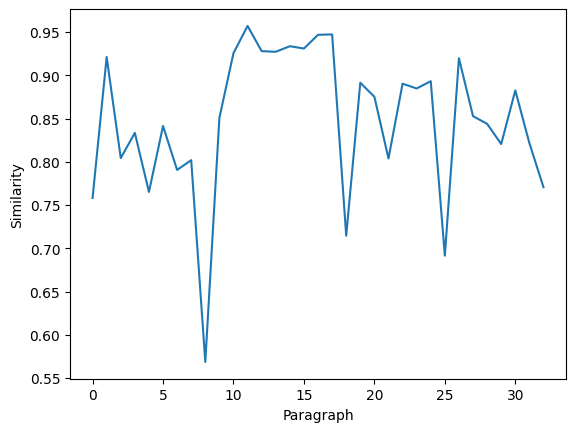

In [16]:
corpus = phrase_aggregator(elaborate_corpus(load_dataset(filename)))
#calculate array of similarity
similarity_basic = calc_basic_similarity_metrics(corpus)

#Plot
plt.plot(range(len(similarity_basic)), similarity_basic)
plt.xlabel('Paragraph')
plt.ylabel('Similarity')
plt.show()

Split the document byt selecting the SPLIT_NUMBER minimum similarity points

In [17]:
print("Split in position:",np.argsort(similarity_basic[0:len(similarity_basic)])[:SPLIT_NUMBER])
for index in np.argsort(similarity_basic[1:len(similarity_basic) - 1])[:SPLIT_NUMBER]:
    print("Last paragraph of split:",corpus[index],"\n")

Split in position: [ 8 25 18]
Last paragraph of split: many tropical country mango revere king fruit due exceptional taste cultural significance apart culinary allure mango cultural religious significance many region often associate abundance prosperity fertility incorporate traditional ceremony festivity 

Last paragraph of split: club success cement status symbol italian football excellence garner loyal global fan base field juventus actively involve various community initiative charitable endeavor use power football make positive impact society club strong sense social responsibility actively support initiative relate education health social inclusion 

Last paragraph of split: lesson learn crisis prompt reevaluation economic financial theory lead renew focus risk management sustainable growth inclusive economic policy crisis highlight interconnectedness interdependence global financial system emphasize need international cooperation address economic challenge conclusion financial c

## Advanced Approach
Calculating prototype centroids for each cut, the similarly now is the cosine similarity between each embedded paragraph and centroids calculated ad average between previous paragraph

## Core functions

In [18]:
#Calculate the similarity for each cut working on a prototype centroid for each cut and calculating cosine similarity between paragraph and centroid
def calc_prototype_similarity_metrics(corpus):
    embeddings = calc_embedding(corpus)
    prototype=[]
    count=0
    similarity = []
    #For each sentence
    for index, embed in enumerate(embeddings):
        # If we don't have a prototype
        if len(prototype) == 0:
            #Initialize the prototype as actual embedding
            prototype=embed
            similarity.append(1)
            count=1
        #If we already have a prototype
        elif len(prototype) > 0:
            #Calculate and store similarity between embedding and prototype
            protoSim=cosine_similarity([embed], [prototype])[0][0]
            similarity.append(protoSim)
            # If similarity between the embedding and the prototype is lesser than the similarity between the paragraph and the next pragraph minus a disincentivation factor
            if index < len(embeddings)-1 and protoSim < (cosine_similarity([embed], [embeddings[index + 1]])[0][0])-0.2:
                #We have moved to a new argument so we reinitialize the prototype
                count=1
                prototype = embed
            else:
                #We haven't moved to a new argument so we do weighted avarage and update prototype
                prototype = (prototype*count+embed)/(count+1)
                count+=1

    return similarity[:len(similarity)-1]

## Main

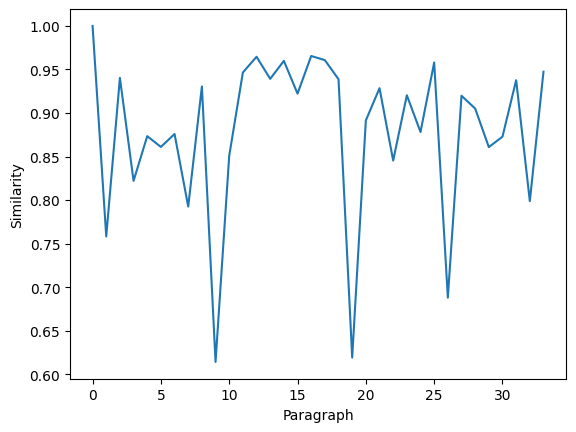

Split in position: [ 9 19 26]
Last paragraph of split: conclusion mango delightful tropical fruit cherish luscious flavor entice aroma vibrant color whether enjoy fresh use various culinary creation mango never fail tantalize taste bud transport u exotic tropical destination next time come across ripe mango indulge tropical delight savor irresistible goodness 

Last paragraph of split: aftermath reshape financial regulation spark debate economic policy prompt rethinking role government financial institution ensure stability sustainable growth lesson learn crisis continue shape economic financial practice today aim prevent future crisis foster resilient global economy juventus football club commonly know juventus juve italian professional football club base turin 

Last paragraph of split: conclusion juventus football symbol passion heritage excellence rich history iconic jersey devote fan base juventus continue driving force italian international football club commitment success field 

In [19]:
#calculate array of similarity
similarity_advanced = calc_prototype_similarity_metrics(corpus)

#Plot
plt.plot(range(len(similarity_advanced)), similarity_advanced)
plt.xlabel('Paragraph')
plt.ylabel('Similarity')
plt.show()
splits = np.argsort(similarity_advanced[0:len(similarity_advanced)])[:SPLIT_NUMBER]
print("Split in position:", splits)
for index in np.argsort(similarity_advanced[1:len(similarity_advanced) - 1])[:SPLIT_NUMBER]:
    print("Last paragraph of split:", corpus[index], "\n")